In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import utils

import gc

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class DQN(nn.Module):

    def __init__(self, c, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(c, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.hidden = nn.Linear(3136, 512, bias=True)
        self.head = nn.Linear(512, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.hidden(x))
        return self.head(x)

In [4]:
env = gym.make('CartPole-v0').unwrapped

In [5]:
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000
TARGET_UPDATE = 10000
MEMORY_SIZE = 10000
HISTORY_LENGTH = 4
SKIP_FRAMES = 4
CHECKPOINT_UPDATE = 2500
CHART_UPDATE = 100

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(HISTORY_LENGTH, n_actions).to(device)
target_net = DQN(HISTORY_LENGTH, n_actions).to(device)

optimizer = optim.RMSprop(policy_net.parameters(), lr=0.00025, eps=0.01, momentum=0.95)

gc.collect()
torch.cuda.empty_cache()

memory = utils.ReplayMemory(MEMORY_SIZE)

steps_done = 0
i_episode = 0
durations = []

frames = deque([], maxlen=HISTORY_LENGTH)

In [6]:
checkpoint_name = ""

if checkpoint_name:
    extra = utils.load_checkpoint(policy_net, optimizer, checkpoint_name)
    memory = extra["memory"]
    steps_done = extra["steps_done"]
    i_episode = extra["i_episode"]
    durations = extra["durations"]

In [7]:
policy_net = policy_net.to(device)
target_net = target_net.to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden): Linear(in_features=3136, out_features=512, bias=True)
  (head): Linear(in_features=512, out_features=2, bias=True)
)

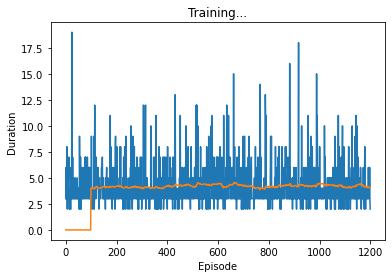

In [ ]:
num_episodes = 1000000
name = "deepminds_dqn"

for _ in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    
    for _ in range(SKIP_FRAMES):
        frames.append(utils.get_screen(env, device))
    state = torch.cat(tuple(frames), 1)
        
    for t in count():
        # Select and perform an action
        action = utils.epsilon_greedy(state, policy_net, steps_done, n_actions, \
                                      device, EPS_START, EPS_END, EPS_DECAY)
        steps_done += 1
        
        # Observe new state
        reward = 0
        for _ in range(SKIP_FRAMES):
            _, p_reward, done, _ = env.step(action.item())
            frames.append(utils.get_screen(env, device))
            reward += p_reward
            if done:
                break
        reward = torch.tensor([reward], device=device)

        if not done:
            next_state = torch.cat(tuple(frames), 1)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        utils.optimize_model(policy_net, target_net, optimizer, memory, device, BATCH_SIZE, GAMMA)
        if done:
            durations.append(t + 1)
            #utils.plot_performance(durations)
            break
            
    i_episode += 1
    
    if i_episode % CHART_UPDATE == 0:
        utils.plot_performance(durations)
    
    if i_episode % CHECKPOINT_UPDATE == 0:
        utils.save_checkpoint(policy_net, optimizer, name+str(i_episode), extra={
            "i_episode": i_episode,
            "steps_done": steps_done,
            "durations": durations,
            "memory": memory
        })
        if i_episode > CHECKPOINT_UPDATE*2:
            utils.delete_checkpoint(name+str(i_episode-(CHECKPOINT_UPDATE*2)))
    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

In [ ]:
env.close()